In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing
from functools import partial
import random
random.seed(0)
import math

In [ ]:
# Constants
N_SIMULATIONS = 100
POINTS_TO_WIN_GAME = 4
POINTS_TO_WIN_TIEBREAK = 7
POINTS_TO_WIN_TIEBREAK_SLAM_LAST_SET = 10 # The last set (or deciding set, or 5th set) tiebreak is 10 points
MIN_MARGIN = 2
SETS_TO_WIN_MATCH_REGULAR = 2
SETS_TO_WIN_MATCH_GRAND_SLAM = 3

In [ ]:
# Players' serving probabilities for left/right service boxes and winning the point
# Players' serving target probabilities for left/right service boxes and targeting a particular direction
player_serve_win_probs = {
    'A': {'left': (0.4, 0.3, 0.3), 'right': (0.2, 0.5, 0.3)},
    'B': {'left': (0.5, 0.35, 0.25), 'right': (0.25, 0.35, 0.4)}
}
player_serve_target_probs = {
    'A': {'left': (0.1, 0.6, 0.3), 'right': (0.5, 0.1, 0.4)},
    'B': {'left': (0.7, 0.1, 0.2), 'right': (0.25, 0.3, 0.45)}
}

In [ ]:
def simulate_point(server, serving_from):
    # Determine the winning probablity based on the server and the serving side (left or right)
    serve_win_probs = player_serve_win_probs[server][serving_from]

    # Determine the target direction (left, middle, or right)
    serve_direction_probs = player_serve_target_probs[server][serving_from]
    target_direction = np.random.choice(['left', 'middle', 'right'],
                                       p =[serve_direction_probs[0], serve_direction_probs[1],
                                           1-serve_direction_probs[0]-serve_direction_probs[1]]
                                       )

    # Determine if the server wins the point based on the chosen and targetting direction
    target_index = 0 if target_direction == 'left' else 1 if target_direction == 'middle' else 2
    point_winner = server if np.random.rand() < serve_win_probs[target_index] else 'A' if server == 'B' else 'B'
    return point_winner

def simulate_game(initial_server):
    score = {'A': 0, 'B': 0}
    server = initial_server
    while True:
        point_winner = simulate_point(server, 'left' if random.random() < 0.5 else 'right')
        score[point_winner] += 1

        if score[point_winner] >= POINTS_TO_WIN_GAME and (score[point_winner] - score['A' if point_winner == 'B' else 'B']) >= MIN_MARGIN:
            break

        server = 'A' if server == 'B' else 'B'

    # Return the winner and the score as a tuple, e.g., ('A', (4, 2))
    return point_winner, (score[point_winner], score['A' if point_winner == 'B' else 'B'])


def simulate_tiebreak(last_server):
    set_score = {'A': 0, 'B': 0}
    server = 'A' if last_server == 'B' else 'B'
    serving_from = 'right'  # alternates between 'left' and 'right'

    # First server only serves for one point and then switch server
    point_winner = simulate_point(server, serving_from)
    set_score[point_winner] += 1
    serving_from = 'left' if serving_from == 'right' else 'right'
    server = 'A' if server == 'B' else 'B'

    while True:
        # Every player serves for two points
        for _ in range(2):
            point_winner = simulate_point(server, serving_from)
            set_score[point_winner] += 1

            # Check for tiebreak winner
            if set_score[point_winner] >= POINTS_TO_WIN_TIEBREAK and (set_score[point_winner] - set_score['A' if point_winner == 'B' else 'B']) >= MIN_MARGIN:
                return point_winner

            # Alternate serving side
            serving_from = 'left' if serving_from == 'right' else 'right'

        server = 'A' if server == 'B' else 'B'

def simulate_set(initial_serve):
    game_scores = []
    set_score = {'A': 0, 'B': 0}
    server = initial_serve
    while True:
        game_winner, game_score = simulate_game(server)
        game_scores.append(game_score)  # Store the game score
        set_score[game_winner] += 1

        # Check for set winner
        if (set_score[game_winner] >= 6 and (set_score[game_winner] - set_score['A' if game_winner == 'B' else 'B']) >= MIN_MARGIN) or set_score[game_winner] == 7:
            initial_server = server # pass the last server to the simulate_match function
            return game_winner, game_scores

        # Check for tiebreak
        if (set_score[game_winner] == 6 and set_score['A' if game_winner == 'B' else 'B'] == 6):
            simulate_tiebreak(server)

        server = 'A' if server == 'B' else 'B'

def simulate_match(sets_to_win):
    match_scores = []
    match_score = {'A': 0, 'B': 0}
    initial_server = random.choice(['A', 'B'])

    while True:
        set_winner, set_game_scores = simulate_set(initial_server)
        match_scores.append((set_winner, set_game_scores))  # Store set winner and game scores
        match_score[set_winner] += 1

        # Check if either player has won the required number of sets to win the match
        if match_score[set_winner] == sets_to_win:
            match_winner = set_winner  # Define the match winner
            break

        initial_server = 'A' if initial_server == 'B' else 'B'  # Switch initial server for next set

    return match_winner, match_scores


In [ ]:
def simulate_match(sets_to_win):
    match_scores = []
    match_score = {'A': 0, 'B': 0}
    initial_server = random.choice(['A', 'B'])

    while True:
        set_winner, set_game_scores = simulate_set(initial_server)
        # Convert game scores to a string representation
        set_game_scores_str = ",".join([f"{score[0]}-{score[1]}" for score in set_game_scores])
        match_scores.append((set_winner, set_game_scores_str))

        match_score[set_winner] += 1

        # Check match winner
        if match_score[set_winner] == sets_to_win:
            match_winner = set_winner
            break

        initial_server = 'A' if initial_server == 'B' else 'B'

    # Return a tuple of tuples
    match_scores_tuple = tuple(match_scores)
    return match_winner, match_scores_tuple

def simulate_matches(num_simulations, sets_to_win):
    all_match_results = []  # List to store all match results

    for _ in range(num_simulations):
        winner, match_score = simulate_match(sets_to_win)
        all_match_results.append((winner, match_score))

    return all_match_results


def aggregate_results(results):
    total_wins = {'A': 0, 'B': 0}
    detailed_scores = []

    for match_result in results:
        winner, match_score = match_result
        total_wins[winner] += 1

    # Format the match scores as 'A:B' before appending
        formatted_scores = [f"{score[0]}:{score[1]}" for score in match_score]
        detailed_scores.extend(formatted_scores)


    return total_wins, detailed_scores


# Start the timer
start_time = time.time()

# Determine the number of processes to create based on the available CPU cores
N_PROCESSES = multiprocessing.cpu_count()
# Calculate the number of simulations each process will handle
chunk_size = N_SIMULATIONS // N_PROCESSES

# Create partial functions with the 'sets_to_win' argument already set
simulate_regular = partial(simulate_matches, sets_to_win=SETS_TO_WIN_MATCH_REGULAR)
simulate_grand_slam = partial(simulate_matches, sets_to_win=SETS_TO_WIN_MATCH_GRAND_SLAM)
with multiprocessing.Pool(processes=N_PROCESSES) as pool:
    regular_results = pool.map(simulate_regular, [chunk_size for _ in range(N_PROCESSES)])
    grand_slam_results = pool.map(simulate_grand_slam, [chunk_size for _ in range(N_PROCESSES)])

# Flatten the results from all processes
flat_regular_results = [item for sublist in regular_results for item in sublist]
flat_grand_slam_results = [item for sublist in grand_slam_results for item in sublist]

# Aggregate the flattened results
regular_match_totals, regular_detailed_scores = aggregate_results(flat_regular_results)
grand_slam_match_totals, grand_slam_detailed_scores = aggregate_results(flat_grand_slam_results)

# Stop the timer and calculate elapsed time
end_time = time.time()

In [ ]:
print(flat_regular_results[:2])
print(flat_grand_slam_results[:2])

[('B', (('B', '4-0,4-0,4-1,9-7,7-5,5-3,8-6,4-1,4-1'), ('B', '4-1,7-5,4-2,4-1,4-2,4-1,6-4,15-13,6-4,4-0'))), ('B', (('B', '4-2,4-1,4-2,4-1,4-2,4-1,4-1,4-1,4-1,4-2,4-2,4-1,4-2'), ('B', '4-2,4-2,4-2,7-5,4-1,6-4,5-3')))]
[('B', (('B', '12-10,4-2,5-3,4-1,4-2,10-8,4-1,4-0'), ('B', '4-2,6-4,5-3,5-3,4-0,4-2,4-1,4-2,4-1,5-3,4-1,4-1'), ('B', '4-1,4-2,4-1,4-2,4-2,4-2,4-0,5-3,4-1,4-0,7-5,5-3'))), ('B', (('B', '6-4,5-3,4-1,4-2,4-1,4-1,4-2,5-3,4-2'), ('B', '4-1,5-3,6-4,12-10,4-2,4-1,4-2,6-4'), ('B', '4-1,4-0,6-4,4-1,4-1,4-2,4-1,7-5')))]


In [ ]:
def extract_win_counts(detailed_results):
    win_counts = {'A': 0, 'B': 0}
    for result in detailed_results:
        winner = result[0][0]  # The winner is the first element of the first element in each tuple
        win_counts[winner] += 1
    return win_counts

# Extract win counts from the regular and grand slam match results
regular_win_counts = extract_win_counts(regular_detailed_scores)
grand_slam_win_counts = extract_win_counts(grand_slam_detailed_scores)

# Calculate probabilities
regular_match_probabilities = {player: wins / N_SIMULATIONS for player, wins in regular_win_counts.items()}
grand_slam_match_probabilities = {player: wins / N_SIMULATIONS for player, wins in grand_slam_win_counts.items()}

# Print the calculated probabilities and the elapsed time
print("Regular Match Probabilities: ", regular_match_probabilities)
print("Grand Slam Match Probabilities: ", grand_slam_match_probabilities)
print("Time elapsed: ", end_time - start_time)

Regular Match Probabilities:  {'A': 0.36, 'B': 1.91}
Grand Slam Match Probabilities:  {'A': 0.57, 'B': 2.98}
Time elapsed:  1.7147667407989502


In [ ]:
from collections import Counter

def extract_game_scores(match_results):
    game_scores = []

    for match_winner, sets in match_results:
        # Initialize set win counters for the match
        set_wins = {'A': 0, 'B': 0}

        for set_winner, _ in sets:
            set_wins[set_winner] += 1

        # Determine the game score for the match
        game_score = f"{set_wins['A']}-{set_wins['B']}"
        game_scores.append(game_score)

    return game_scores

# Process the match results to extract game scores
regular_game_scores = extract_game_scores(flat_regular_results)
grand_slam_game_scores = extract_game_scores(flat_grand_slam_results)

In [ ]:
print(regular_game_scores[:10])
print(grand_slam_game_scores[:40])

['0-2', '0-2', '0-2', '1-2', '0-2', '0-2', '0-2', '0-2', '0-2', '0-2']
['0-3', '0-3', '0-3', '0-3', '2-3', '0-3', '0-3', '1-3', '0-3', '1-3', '0-3', '0-3', '1-3', '0-3', '0-3', '2-3', '1-3', '2-3', '0-3', '0-3', '2-3', '0-3', '2-3', '0-3', '0-3', '0-3', '1-3', '1-3', '0-3', '2-3', '0-3', '0-3', '0-3', '0-3', '1-3', '0-3', '1-3', '1-3', '0-3', '2-3']


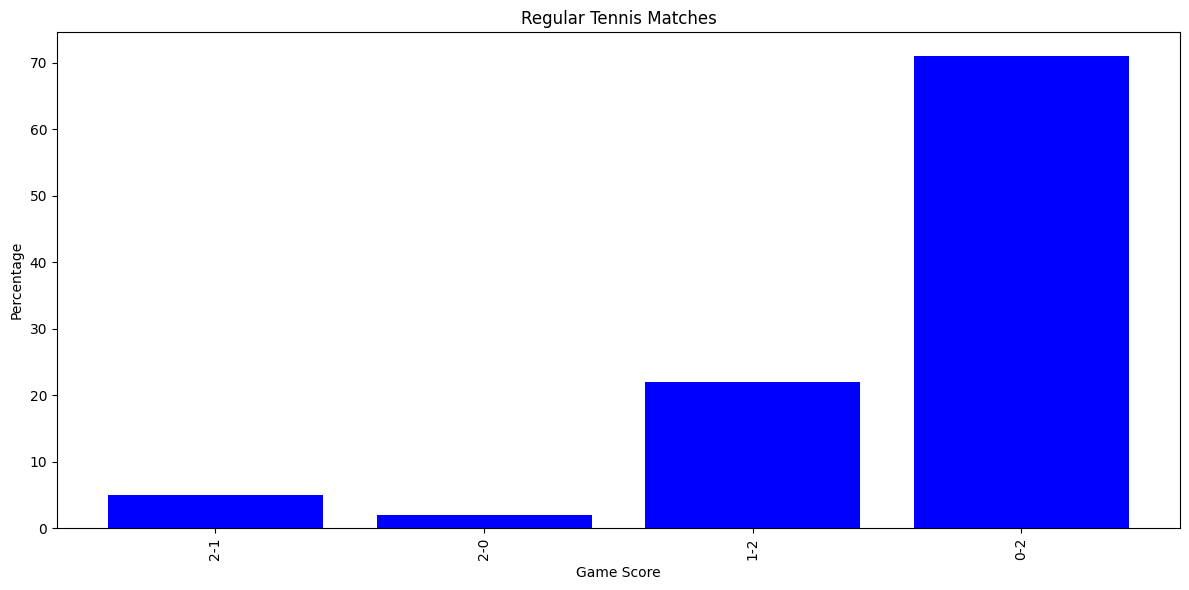

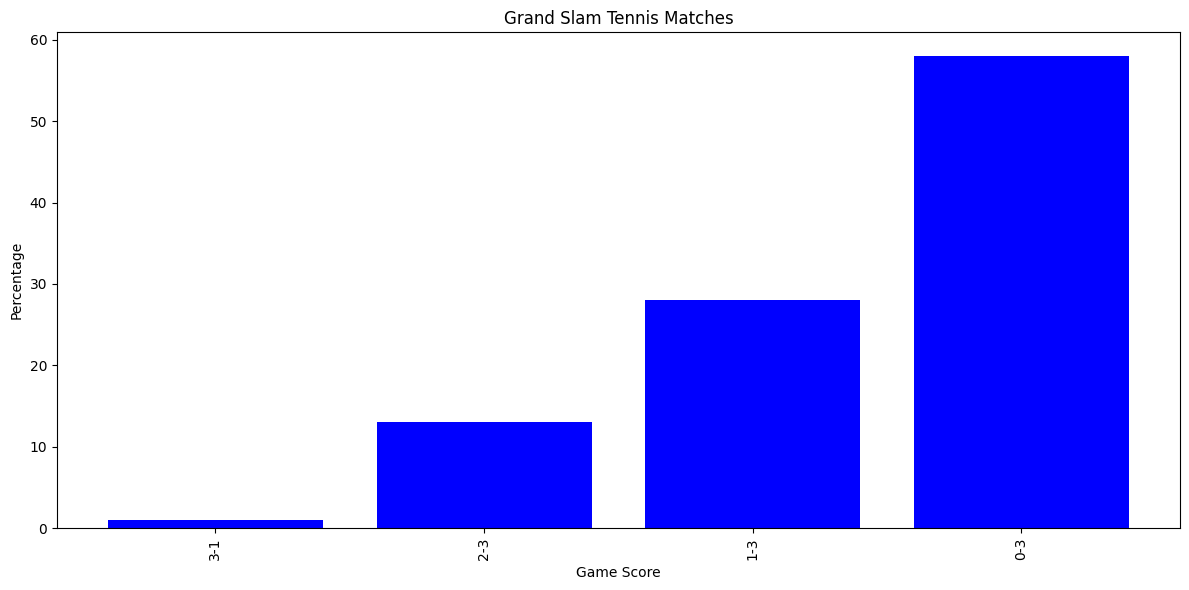

In [ ]:
def plot_sorted_game_scores(sorted_scores, title):
    if not sorted_scores:
        print(f"No data to plot for {title}")
        return

    scores, counts = zip(*sorted_scores)
    percentages = [count / sum(counts) * 100 for count in counts]

    plt.figure(figsize=(12, 6))
    plt.bar(scores, percentages, color='blue')
    plt.xlabel('Game Score')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def separate_and_plot_scores(game_scores, title):
    # Counting game scores
    score_counter = Counter(game_scores)

    # Sorting the scores by the first player's wins
    sorted_scores = sorted(score_counter.items(), key=lambda x: int(x[0].split('-')[0]), reverse=True)

    # Plotting
    plot_sorted_game_scores(sorted_scores, title)

# Example usage
separate_and_plot_scores(regular_game_scores, 'Regular Tennis Matches')
separate_and_plot_scores(grand_slam_game_scores, 'Grand Slam Tennis Matches')


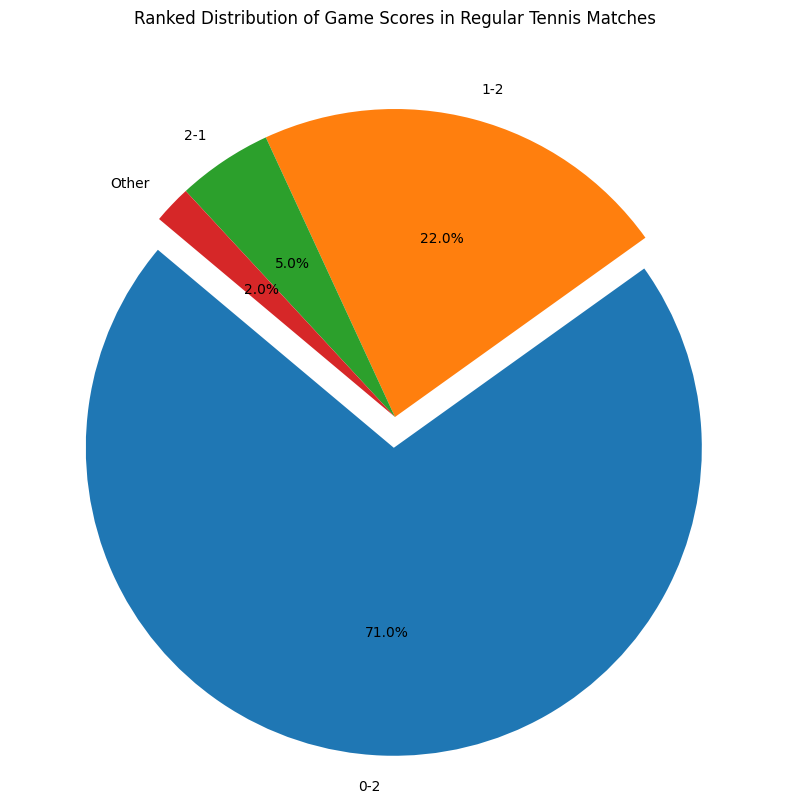

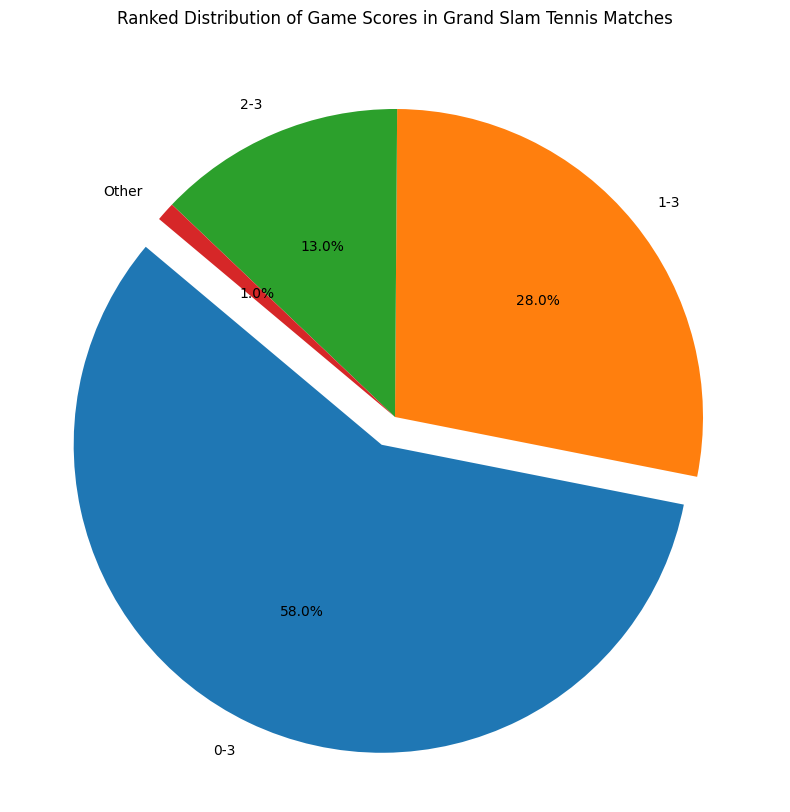

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Function to process and plot game scores
def process_and_plot_game_scores(game_scores, title):
    score_counter = Counter(game_scores)
    total_counts = sum(score_counter.values())

    # Threshold for combining small slices into "Other"
    threshold = 0.05  # 5% threshold

    # Separate large and small slices
    large_scores = {score: count for score, count in score_counter.items() if count / total_counts >= threshold}
    small_scores = {score: count for score, count in score_counter.items() if count / total_counts < threshold}

    # Combine small slices into "Other"
    large_scores['Other'] = sum(small_scores.values())

    # Sort the large_scores by count in descending order
    sorted_large_scores = sorted(large_scores.items(), key=lambda item: item[1], reverse=True)

    # Unpack the sorted scores and counts
    sorted_scores, sorted_counts = zip(*sorted_large_scores)

    # Calculate percentages
    percentages = [count / total_counts * 100 for count in sorted_counts]

    # Explode the largest slice
    explode = [0.1] + [0 for _ in range(len(sorted_scores) - 1)]

    # Plotting the pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(percentages, labels=sorted_scores, autopct='%1.1f%%', startangle=140, explode=explode)
    plt.title(title)
    plt.show()

# Process and plot regular game scores
process_and_plot_game_scores(regular_game_scores, 'Ranked Distribution of Game Scores in Regular Tennis Matches')

# Process and plot Grand Slam game scores
process_and_plot_game_scores(grand_slam_game_scores, 'Ranked Distribution of Game Scores in Grand Slam Tennis Matches')


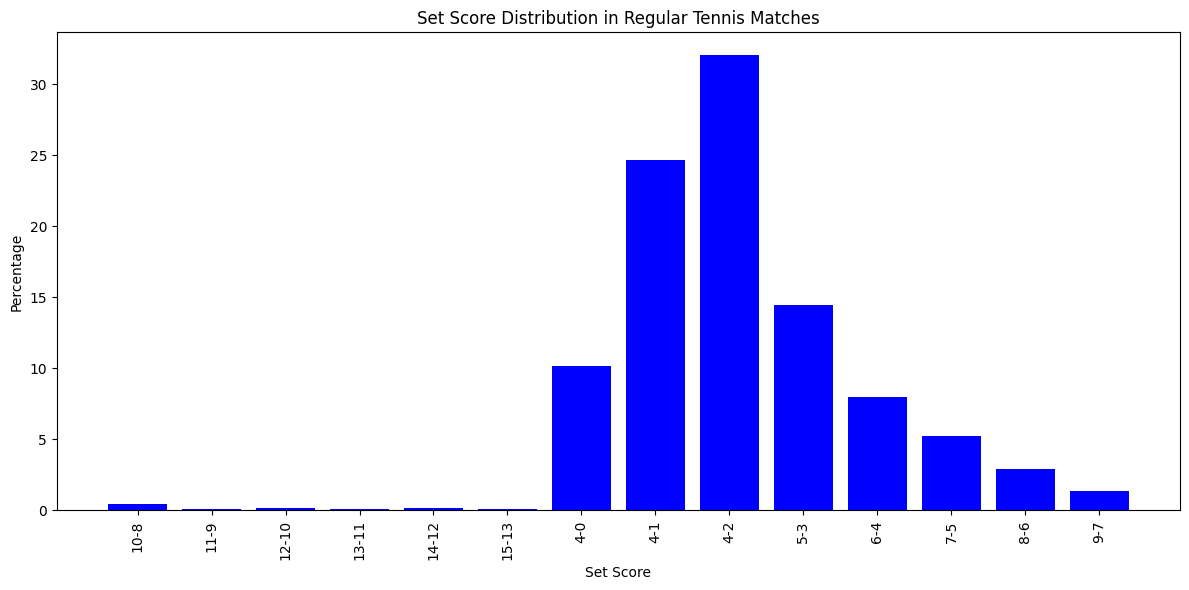

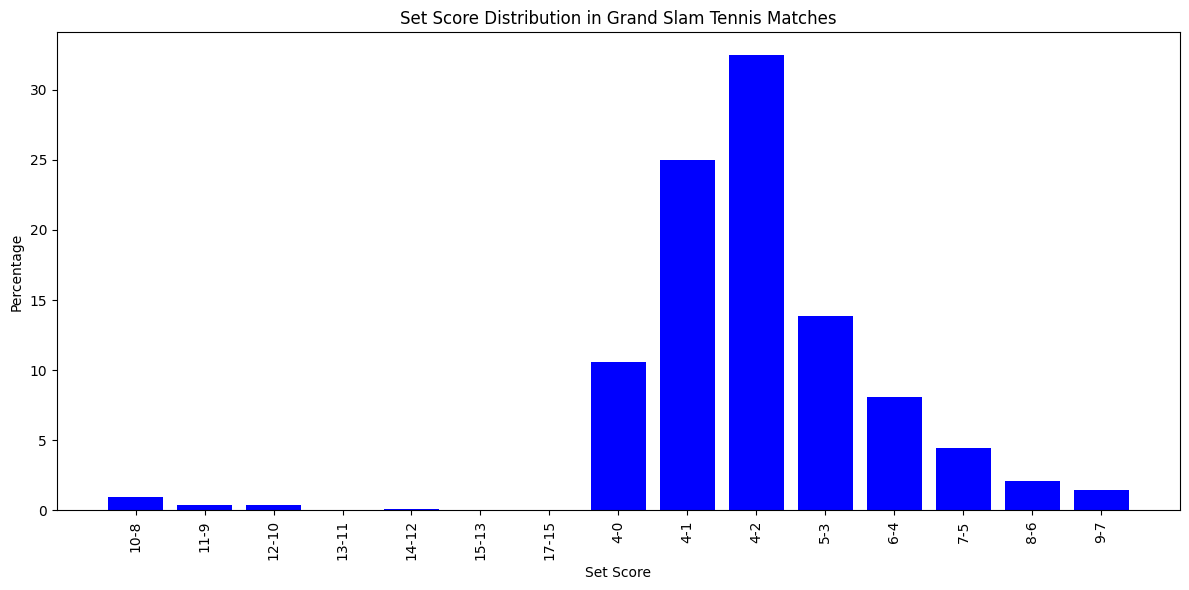

In [ ]:
def extract_set_scores(match_results):
    set_scores = []

    for _, sets in match_results:
        for _, set_scores_str in sets:
            scores = set_scores_str.split(',')
            set_scores.extend(scores)

    return set_scores

def plot_set_scores(set_scores, title):
    score_counter = Counter(set_scores)
    sorted_scores = sorted(score_counter.items(), key=lambda x: x[0])

    scores, counts = zip(*sorted_scores)
    percentages = [count / sum(counts) * 100 for count in counts]

    plt.figure(figsize=(12, 6))
    plt.bar(scores, percentages, color='blue')
    plt.xlabel('Set Score')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Extract set scores from regular and Grand Slam matches
regular_set_scores = extract_set_scores(flat_regular_results)
grand_slam_set_scores = extract_set_scores(flat_grand_slam_results)

# Plotting the set score distributions
plot_set_scores(regular_set_scores, 'Set Score Distribution in Regular Tennis Matches')
plot_set_scores(grand_slam_set_scores, 'Set Score Distribution in Grand Slam Tennis Matches')

In [ ]:
print(flat_regular_results[:10])
print(regular_set_scores[:10])

[('B', (('B', '4-0,4-0,4-1,9-7,7-5,5-3,8-6,4-1,4-1'), ('B', '4-1,7-5,4-2,4-1,4-2,4-1,6-4,15-13,6-4,4-0'))), ('B', (('B', '4-2,4-1,4-2,4-1,4-2,4-1,4-1,4-1,4-1,4-2,4-2,4-1,4-2'), ('B', '4-2,4-2,4-2,7-5,4-1,6-4,5-3'))), ('B', (('B', '4-1,4-2,4-2,9-7,9-7,4-0,4-2'), ('B', '4-1,5-3,4-1,4-1,4-2,4-1,6-4,10-8,4-2,4-2'))), ('B', (('B', '4-2,7-5,5-3,4-1,4-0,4-1,4-2,4-2'), ('A', '4-2,6-4,4-1,5-3,4-2,10-8,4-0,4-1,4-0,4-2,4-1,4-2'), ('B', '4-0,15-13,4-1,4-2,4-1,4-2,4-2,4-2'))), ('B', (('B', '10-8,4-2,4-2,4-2,4-2,8-6,4-1,4-1'), ('B', '4-1,4-1,8-6,4-1,4-2,6-4,5-3,4-1,4-2,4-1'))), ('B', (('B', '4-2,13-11,5-3,4-1,4-1,4-2,4-2'), ('B', '4-1,5-3,4-0,4-1,6-4,7-5,4-2,4-2,4-1'))), ('B', (('B', '4-2,4-2,6-4,4-1,4-1,5-3,5-3,5-3,8-6,4-1,6-4,4-1'), ('B', '4-1,4-1,4-1,4-1,4-2,4-2,5-3,6-4,7-5,4-2'))), ('B', (('B', '9-7,4-2,4-2,4-2,4-1,6-4,4-2'), ('B', '7-5,4-2,4-2,4-2,4-2,4-0,4-0,7-5,4-1'))), ('B', (('B', '5-3,4-2,4-1,7-5,6-4,4-2,4-0,4-1'), ('B', '5-3,8-6,4-2,4-2,9-7,6-4,5-3'))), ('B', (('B', '4-0,5-3,5-3,5-3,4-1,5

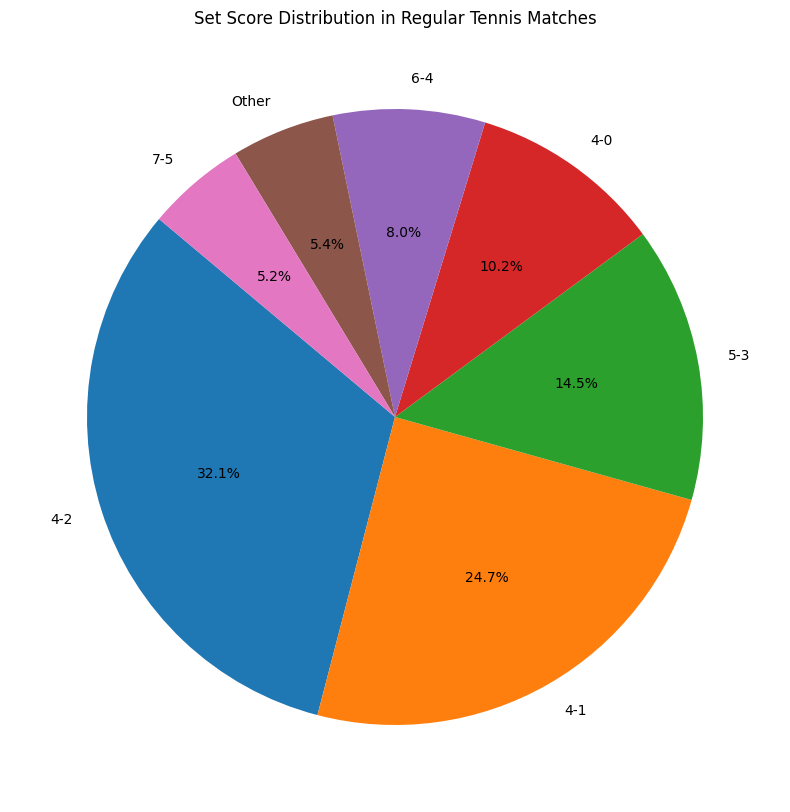

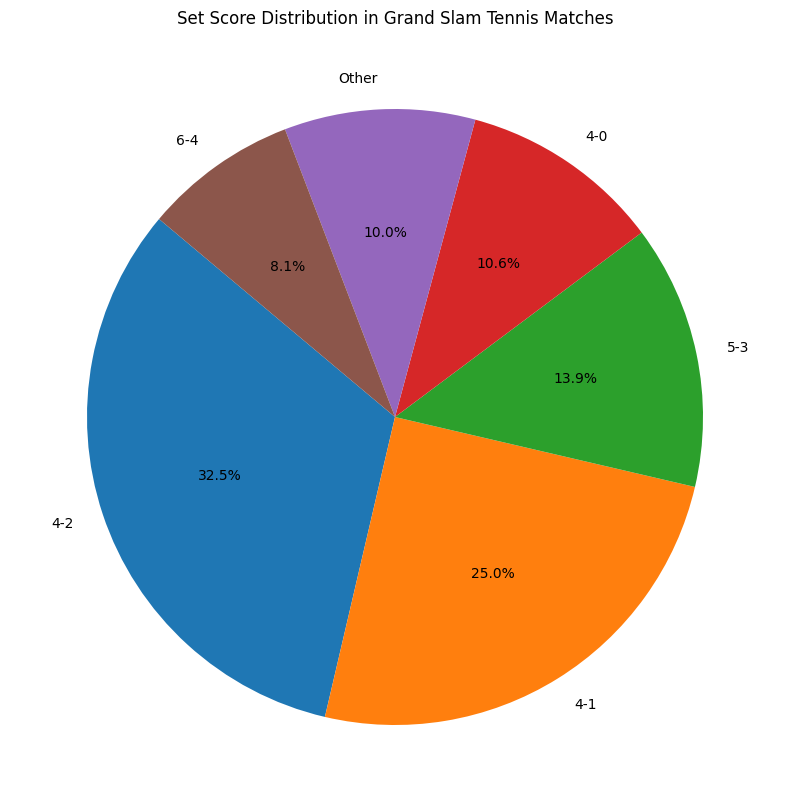

In [ ]:
def plot_set_scores_pie_chart(set_scores, title, threshold=0.05):  # 5% threshold
    score_counter = Counter(set_scores)
    total_counts = sum(score_counter.values())

    # Separate more common scores from less common ones
    common_scores = {score: count for score, count in score_counter.items() if count / total_counts >= threshold}
    other_scores = {score: count for score, count in score_counter.items() if count / total_counts < threshold}

    # Combine less common scores into "Other"
    common_scores['Other'] = sum(other_scores.values())

    # Sorting scores for a cleaner pie chart
    sorted_scores = sorted(common_scores.items(), key=lambda x: x[1], reverse=True)

    scores, counts = zip(*sorted_scores)
    percentages = [count / total_counts * 100 for count in counts]

    plt.figure(figsize=(10, 10))
    plt.pie(percentages, labels=scores, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Extract set scores from regular and Grand Slam matches
regular_set_scores = extract_set_scores(flat_regular_results)
grand_slam_set_scores = extract_set_scores(flat_grand_slam_results)

# Plotting the set score distributions as pie charts
plot_set_scores_pie_chart(regular_set_scores, 'Set Score Distribution in Regular Tennis Matches')
plot_set_scores_pie_chart(grand_slam_set_scores, 'Set Score Distribution in Grand Slam Tennis Matches')

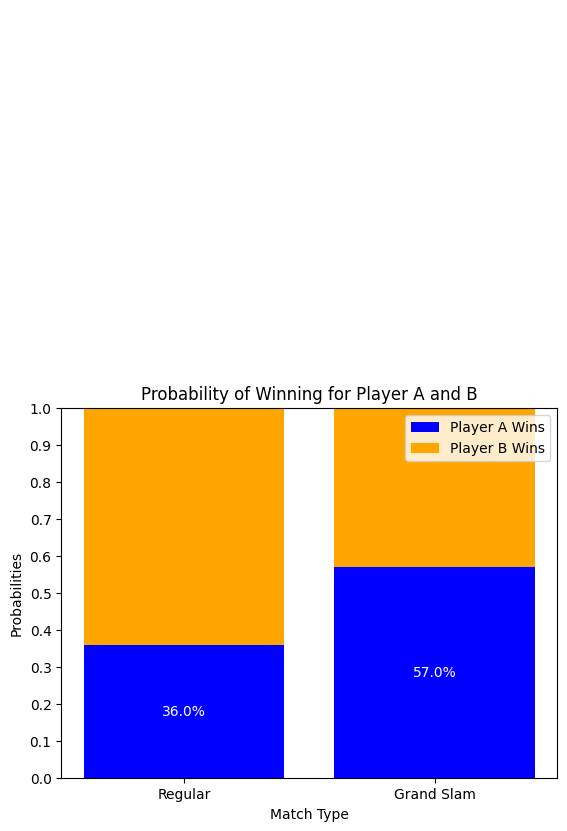

In [ ]:
# Data for stacking
regular_a = regular_match_probabilities['A']
regular_b = regular_match_probabilities['B']
grand_slam_a = grand_slam_match_probabilities['A']
grand_slam_b = grand_slam_match_probabilities['B']

# Positions of the bars on the x-axis
ind = np.arange(2)

# Heights of the A and B portions
p1 = [regular_a, grand_slam_a]
p2 = [regular_b, grand_slam_b]

# Plotting
fig, ax = plt.subplots()

# Stack 'A' and 'B' for each match type
bars_a = ax.bar(ind, p1, label='Player A Wins', color='blue')
bars_b = ax.bar(ind, p2, bottom=p1, label='Player B Wins', color='orange')

# Adding labels and title
ax.set_xlabel('Match Type')
ax.set_ylabel('Probabilities')
ax.set_title('Probability of Winning for Player A and B')
ax.set_xticks(ind)
ax.set_xticklabels(['Regular', 'Grand Slam'])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim([0, 1])  # Set y-axis to go from 0 to 1
ax.legend()

# Adding the percentage on top of the bars
for r1, r2 in zip(bars_a, bars_b):
    h1 = r1.get_height()
    h2 = r2.get_height()
    ax.text(r1.get_x() + r1.get_width() / 2., h1 / 2., f'{h1:.1%}', ha='center', va='center', color='white')
    ax.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., f'{h2:.1%}', ha='center', va='center', color='white')

# Show plot
plt.show()
